In [3]:
using ProgressBars;

using LinearAlgebra, Plots;
function plus(x)
    return max(x, 0)
end

function minus(x)
    return max(-x, 0)
end

function create_D_vecs(u_vec, t_n, h, C_H) # returns Dplusminus and Dminusplus vectors
    Dplus = [diff(u_vec); 0] ./ h
    Dminus = [0; diff(u_vec)] ./ h
    Dplus[end] = (u_vec[1] - u_vec[end]) / h
    Dminus[1]= (u_vec[1] - u_vec[end]) / h 
    Dplusminus = minus.(Dplus)
    Dminusplus = plus.(Dminus)
    Dplusplus = plus.(Dplus)
    Dminusminus = minus.(Dminus)
    return C_H .* (Dplusminus, Dminusplus, Dplusplus, Dminusminus)
end

function g_func(u_vec, t_n, h, C_H)
    (Dplusminus, Dminusplus, temp, temp) = create_D_vecs(u_vec, t_n, h, C_H)
    return C_H .* (Dplusminus .^2 + Dminusplus .^2)
end

function create_Dg_mat(v, t_n, N_h, h, C_H) # verified is correct
    (Dplusminus, Dminusplus, temp, temp) = create_D_vecs(v, t_n, h, C_H);
    Dg_mat = zeros(N_h, N_h)
    tridiag = Tridiagonal(-Dminusplus[2:end], Dplusminus + Dminusplus, -Dplusminus[1:end-1])
    Dg_mat[1, N_h] = -Dminusplus[1]
    Dg_mat[N_h, 1] = -Dplusminus[end]
    Dg_mat += tridiag
    Dg_mat *= 2/h
    return Dg_mat
end
using SpecialFunctions: gamma, loggamma, zeta
function TS(m, α, N_h, R)
    if m==0
        return 0
    end
    K_α = 0.0
    for ν in -R:1:R
        K_α += exp( loggamma( abs(m - N_h*ν) - α/2 )  - loggamma( ( abs(m - N_h*ν) + 1 + α/2) )  )
    end
    return K_α
end
    

function create_DPL_matrix(N_h, α, h, R)
    DPL_mat = Matrix{Float64}(undef, N_h, N_h)
    zeta_term= zeta(1+α)
    for i in 1:N_h
        for j in 1:N_h
            DPL_mat[i,j] = TS(abs(i-j), α, N_h, R)
        end
    end
    for γ in 1:N_h
        DPL_mat[γ, γ] = -(sum([TS(β-γ, α, N_h, R) for β in 1:N_h]) + 2*zeta_term - 
        sum([1/k^(1+α) for k in 1:((R+1)*N_h - γ) ]) - sum([1/k^(1+α) for k in 1:(R*N_h + γ - 1) ]))
    end
    c_α = 2^α * gamma((1+α)/2) / (√π * abs(gamma(-α/2)) )
    return -c_α / (h^α) * DPL_mat
end

function tranport_matrix(U, t_n, N_h, h, C_H) # verified!
    (DPM, DMP, DPP, DMM) = create_D_vecs(U, t_n, h, C_H);
    TU_mat = zeros(N_h, N_h)
    tridiag = Tridiagonal(DMM[2:end], -DPM - DMP, DPP[1:end-1])
    TU_mat[1, N_h] = DMM[1]
    TU_mat[N_h, 1] = DPP[end]
    # tridiag = Tridiagonal(DMM[1:end-1], -(DMP + DPM), DPP[2:end])
    # TU_mat[1, N_h] = DMM[end]
    # TU_mat[N_h, 1] = DPP[1]
    TU_mat += tridiag
    TU_mat *= 2/h # not by h
    return TU_mat
end


function mathcalF(U_np1, U_n, M_n, DPL_matrix, x_vec, n, N_h, Δt, h, ν, α, R,δ, C_H)
    return U_np1 - U_n + Δt*( ν*DPL_matrix*U_np1 + g_func(U_np1, n*Δt, h, C_H) - F_h(M_n, x_vec, 2-n*Δt,δ))
end

function J_F(x, DPL_matrix, t_n, N_h, Δt, h, ν, α, R, C_H) # verified is correct
    Dg_mat = create_Dg_mat(x, t_n, N_h, h, C_H)
    return 1.0I(N_h) + Δt*(ν*DPL_matrix + Dg_mat)
end

function HJB_step(U_n, M_n, DPL_matrix, num_it_HJB, x_vec, n, N_h, Δt, h, ν, α, R,δ,C_H)
    U_np1 = U_n 
    for _ in num_it_HJB
        jacobi = J_F(U_np1, DPL_matrix, n*Δt, N_h, Δt, h, ν, α, R, C_H)
        F_vec = mathcalF(U_np1, U_n, M_n, DPL_matrix, x_vec, n, N_h, Δt, h, ν, α, R,δ,C_H)
        δ = jacobi \ F_vec
        U_np1 = U_np1 - δ
    end
    return U_np1
end

function HJB_solve(M_mat, num_it_HJB, x_vec, N_h, Δt, N_T, h, ν, α, R, δ, C_H)
    U_mat = Array{Float64}(undef, N_h, N_T)
    U_mat[:,1] = G_h(M_mat[:,1])
    DPL_matrix = create_DPL_matrix(N_h, α, h, R)
    for n in 1:(N_T-1)
        U_mat[:, n+1]= HJB_step(U_mat[:, n], M_mat[:, n], DPL_matrix, num_it_HJB, x_vec, n, N_h, Δt, h, ν, α, R,δ,C_H)
    end
    return U_mat
end

function FPK_step(U_np1, M_np1, n, DPL_mat, N_h, Δt, h, ν, α, R, C_H) # not exactly verified, but DPL and TU is verified.
    TU = tranport_matrix(U_np1, n*Δt, N_h, h, C_H)
    total_mat = 1.0I(N_h) + Δt *(ν*DPL_mat - TU)
    M_n = total_mat \ M_np1
    return M_n
end
function FPK_solve(U_mat, M_T, N_h, Δt, N_T, h, ν, α, R, C_H)
    M_mat = Array{Float64}(undef, N_h, N_T)
    M_mat[:,end] = M_T
    DPL_mat = create_DPL_matrix(N_h, α, h, R)
    for j in 1:(N_T-1)
        M_mat[:, N_T-j]= FPK_step(U_mat[:, N_T-j+1], M_mat[:, N_T-j+1], N_T-j+1, DPL_mat, N_h, Δt, h, ν, α, R, C_H)
    end
    return M_mat
end

function MFG_solve(M_T, cv)
    (α, h, N_h, Δt, N_T, ν, num_it_MFG, num_it_HJB, x_vec, R, δ, C_H) = cv;
    M_mat = Array{Float64}(undef, N_h, N_T); M_mat .= M_T;
    U_mat = Array{Float64}(undef, N_h, N_T);
    for _ in ProgressBar(1:num_it_MFG)
        U_mat = HJB_solve(M_mat, num_it_HJB, x_vec, N_h, Δt, N_T, h, ν, α, R, δ, C_H)
        M_mat = FPK_solve(U_mat, M_T, N_h, Δt, N_T, h, ν, α, R, C_H)
    end
    return (U_mat, M_mat)
end

using QuadGK;

function ϕ_δ(x, δ)
    1/(δ* sqrt(2*π)) * exp(-x^2 / (2*δ^2))
end

function conv_term(m_vec, x_vec, δ)
    h = x_vec[2] - x_vec[1]
    N_h = length(m_vec)
    conv_vec = Vector{Float64}(undef, N_h)
    for j in 1:N_h
        conv_vec[j] = h*sum( [ m_vec[i] * ϕ_δ(x_vec[j] - x_vec[i],δ) for i in 1:N_h]) # * h
    end
    return conv_vec
end

# f_func = (x, t) -> cos(2*pi*(x-t^2))^2
f_func = (x, t) -> 5*(x − 0.5(1 − sin(2*π*t)))^2

function F_h(M, x_vec, t_n,δ)
    ϕm = conv_term(M, x_vec,δ)
    fⁿ = [f_func(x_i, t_n) for x_i in x_vec]
    return ϕm + fⁿ
end

### INITIAL AND TERMINAL CONDITIONS

function G_h(M)
    return zeros(length(M))
end

# m_T_func_unnorm = (x) -> exp(-50*(x-0.5)^2)
m_T_func_unnorm = (x) -> exp(-(x-0.5)^2/0.1^2)
oneOverC, error = quadgk(m_T_func_unnorm, 0, 1);

function m_T_func(x)
    return 1/oneOverC * m_T_func_unnorm(x) 
end

m_T_func (generic function with 1 method)

In [4]:
using DelimitedFiles;
println("START")
### Solution for different h

h_reference = 1/2^12
h_list = [1/2^5, 1/2^6, 1/2^7,1/2^8, 1/2^9, h_reference]

M_list = Array{Float64}[]
U_list = Array{Float64}[]

println("hlist: ", h_list)
println("h_reference: ", h_reference)
println("M_list: ", M_list)
println("U_list", U_list)

for h in h_list
    println("")
    println("start for loop, h=", h)
    ####### NB Might take some time to run
    α = 1.0 #1.5
    x_vec = -1:h:(2-h);
    N_h =length(x_vec);
    Δt = 0.01
    t_vec = 0:Δt:(1-Δt)
    N_T =length(t_vec)
    ν=0.09^2
    num_it_MFG=50
    num_it_HJB=20
    δ = 0.4
    R=30
    C_H = 0.5
    cv = (α, h, N_h, Δt, N_T, ν, num_it_MFG, num_it_HJB, x_vec, R, δ, C_H); # create a constant-vector, to avoid clutter for all constants we need.
    println("C_H: ", C_H)
    #terminal condition
    M_T =  m_T_func.(x_vec);

    println("Running MFG_solve with h=", h)
    (U_mat, M_mat) = MFG_solve(M_T, cv);
    M_mat = reverse(M_mat, dims=2);
    U_mat = reverse(U_mat, dims=2);
    ############

    println("Done running MFG_sovle with h=", h)
    #println("M_mat: ")
    #println(M_mat)
    
    println("size(M_mat): ", size(M_mat))
    println("size(U_mat): ", size(U_mat))

    push!(M_list, M_mat)
    push!(U_list, U_mat)
    println("!!!!!!!!!!!!!!")
    writedlm("U_mat_convergence_h_"*string(h)*"deltat_"*string(Δt)*".csv", U_mat, ",")
    writedlm("M_mat_convergence_h_"*string(h)*"deltat_"*string(Δt)*".csv", M_mat, ",")
end

println("DONE")
println("size(M_list): ", size(M_list))
println("size(U_list): ", size(U_list))

START
hlist: [0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.000244140625]
h_reference: 0.000244140625
M_list: Array{Float64}[]
U_listArray{Float64}[]

start for loop, h=0.03125
C_H: 0.5
Running MFG_solve with h=0.03125


0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:00<Inf:Inf, InfGs/it]
4.0%┣██                                              ┫ 2/50 [00:00<00:22, 2it/s]
6.0%┣██▉                                             ┫ 3/50 [00:01<00:15, 3it/s]
8.0%┣███▉                                            ┫ 4/50 [00:01<00:12, 4it/s]
10.0%┣████▊                                          ┫ 5/50 [00:01<00:10, 4it/s]
12.0%┣█████▋                                         ┫ 6/50 [00:01<00:09, 5it/s]
14.0%┣██████▋                                        ┫ 7/50 [00:01<00:09, 5it/s]
16.0%┣███████▌                                       ┫ 8/50 [00:01<00:08, 5it/s]
18.0%┣████████▌                                      ┫ 9/50 [00:01<00:08, 5it/s]
20.0%┣█████████▏                                    ┫ 10/50 [00:02<00:07, 6it/s]
22.0%┣██████████▏                                   ┫ 11/50 [00:02<00:07, 6it/s]
24.0%┣███████████           

Done running MFG_sovle with h=0.03125
size(M_mat): (96, 100)
size(U_mat): (96, 100)
!!!!!!!!!!!!!!



100.0%┣█████████████████████████████████████████████┫ 50/50 [00:07<00:00, 7it/s]
100.0%┣█████████████████████████████████████████████┫ 50/50 [00:07<00:00, 7it/s]



start for loop, h=0.015625
C_H: 0.5
Running MFG_solve with h=0.015625


0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:01<Inf:Inf, InfGs/it]
4.0%┣██                                              ┫ 2/50 [00:02<01:56, 2s/it]
6.0%┣██▉                                             ┫ 3/50 [00:04<01:24, 2s/it]
8.0%┣███▉                                            ┫ 4/50 [00:05<01:14, 2s/it]
10.0%┣████▊                                          ┫ 5/50 [00:06<01:08, 2s/it]
12.0%┣█████▋                                         ┫ 6/50 [00:07<01:04, 1s/it]
14.0%┣██████▋                                        ┫ 7/50 [00:08<01:01, 1s/it]
16.0%┣███████▌                                       ┫ 8/50 [00:10<00:59, 1s/it]
18.0%┣████████▌                                      ┫ 9/50 [00:11<00:57, 1s/it]
20.0%┣█████████▏                                    ┫ 10/50 [00:12<00:55, 1s/it]
22.0%┣██████████▏                                   ┫ 11/50 [00:14<00:53, 1s/it]
24.0%┣███████████           

Done running MFG_sovle with h=0.015625
size(M_mat): (192, 100)
size(U_mat): (192, 100)
!!!!!!!!!!!!!!

start for loop, h=0.0078125
C_H: 0.5
Running MFG_solve with h=0.0078125


100.0%┣█████████████████████████████████████████████┫ 50/50 [01:02<00:00, 1s/it]
100.0%┣█████████████████████████████████████████████┫ 50/50 [01:02<00:00, 1s/it]
0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:03<Inf:Inf, InfGs/it]
4.0%┣██                                              ┫ 2/50 [00:07<05:23, 7s/it]
6.0%┣██▉                                             ┫ 3/50 [00:10<03:54, 5s/it]
8.0%┣███▉                                            ┫ 4/50 [00:13<03:23, 4s/it]
10.0%┣████▊                                          ┫ 5/50 [00:16<03:05, 4s/it]
12.0%┣█████▋                                         ┫ 6/50 [00:20<02:55, 4s/it]
14.0%┣██████▋                                        ┫ 7/50 [00:23<02:48, 4s/it]
16.0%┣███████▌                                       ┫ 8/50 [00:27<02:40, 4s/it]
18.0%┣████████▌                                      ┫ 9/50 [00:30<02:33, 4s/it]
20.0%┣█████████▏            

Done running MFG_sovle with h=0.0078125
size(M_mat): (384, 100)
size(U_mat): (384, 100)
!!!!!!!!!!!!!!

start for loop, h=0.00390625
C_H: 0.5
Running MFG_solve with h=0.00390625


100.0%┣█████████████████████████████████████████████┫ 50/50 [02:45<00:00, 3s/it]
100.0%┣█████████████████████████████████████████████┫ 50/50 [02:45<00:00, 3s/it]
0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:10<Inf:Inf, InfGs/it]
4.0%┣█▉                                             ┫ 2/50 [00:20<16:00, 20s/it]
6.0%┣██▉                                            ┫ 3/50 [00:30<11:47, 15s/it]
8.0%┣███▊                                           ┫ 4/50 [00:40<10:12, 13s/it]
10.0%┣████▋                                         ┫ 5/50 [00:50<09:19, 12s/it]
12.0%┣█████▌                                        ┫ 6/50 [01:00<08:49, 12s/it]
14.0%┣██████▍                                       ┫ 7/50 [01:10<08:21, 12s/it]
16.0%┣███████▍                                      ┫ 8/50 [01:20<07:59, 11s/it]
18.0%┣████████▎                                     ┫ 9/50 [01:30<07:39, 11s/it]
20.0%┣█████████             

Done running MFG_sovle with h=0.00390625
size(M_mat): (768, 100)
size(U_mat): (768, 100)
!!!!!!!!!!!!!!

start for loop, h=0.001953125
C_H: 0.5
Running MFG_solve with h=0.001953125


100.0%┣████████████████████████████████████████████┫ 50/50 [08:23<00:00, 10s/it]
100.0%┣████████████████████████████████████████████┫ 50/50 [08:23<00:00, 10s/it]
0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:39<Inf:Inf, InfGs/it]
4.0%┣█▊                                          ┫ 2/50 [01:19<01:02:50, 79s/it]
6.0%┣██▉                                            ┫ 3/50 [01:59<46:38, 60s/it]
8.0%┣███▊                                           ┫ 4/50 [02:39<40:40, 53s/it]
10.0%┣████▋                                         ┫ 5/50 [03:19<37:17, 50s/it]
12.0%┣█████▌                                        ┫ 6/50 [03:59<34:59, 48s/it]
14.0%┣██████▍                                       ┫ 7/50 [04:38<33:15, 46s/it]
16.0%┣███████▍                                      ┫ 8/50 [05:18<31:47, 45s/it]
18.0%┣████████▎                                     ┫ 9/50 [05:57<30:32, 45s/it]
20.0%┣█████████             

Done running MFG_sovle with h=0.001953125
size(M_mat): (1536, 100)
size(U_mat): (1536, 100)
!!!!!!!!!!!!!!

start for loop, h=0.000244140625
C_H: 0.5
Running MFG_solve with h=0.000244140625



100.0%┣████████████████████████████████████████████┫ 50/50 [32:34<00:00, 40s/it]
100.0%┣████████████████████████████████████████████┫ 50/50 [32:34<00:00, 40s/it]
0.0%┣                                               ┫ 0/50 [00:00<00:00, -0s/it]
2.0%┣▉                                          ┫ 1/50 [57:20<Inf:Inf, InfGs/it]
4.0%┣█▋                                     ┫ 2/50 [01:54:22<91:29:51, 6.9ks/it]
6.0%┣██▍                                    ┫ 3/50 [02:51:11<67:02:51, 5.1ks/it]
8.0%┣███▏                                   ┫ 4/50 [03:48:46<58:27:51, 4.6ks/it]
10.0%┣███▉                                  ┫ 5/50 [04:46:24<53:42:04, 4.3ks/it]
12.0%┣████▋                                 ┫ 6/50 [05:44:00<50:27:10, 4.1ks/it]
14.0%┣█████▎                                ┫ 7/50 [06:40:00<47:46:37, 4.0ks/it]
16.0%┣██████                                ┫ 8/50 [07:36:11<45:37:08, 3.9ks/it]
18.0%┣██████▉                               ┫ 9/50 [08:32:04<43:44:22, 3.8ks/it]
20.0%┣███████▍             

Done running MFG_sovle with h=0.000244140625
size(M_mat): (12288, 100)
size(U_mat): (12288, 100)
!!!!!!!!!!!!!!

100.0%┣███████████████████████████████████████┫ 50/50 [47:13:29<00:00, 3.5ks/it]
100.0%┣███████████████████████████████████████┫ 50/50 [47:13:29<00:00, 3.5ks/it]



DONE
size(M_list): (6,)
size(U_list): (6,)


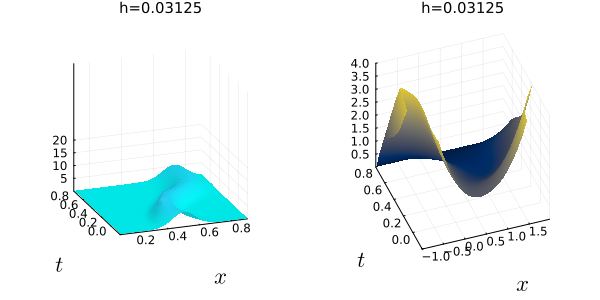

HI
[0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.000244140625]
!!
size(U_list): (6,)
----
i: 1
Display:
!!!!!!!!!
----
i: 2
Display:
!!!!!!!!!
----
i: 3
Display:
!!!!!!!!!
----
i: 4
Display:
!!!!!!!!!
----
i: 5
Display:
!!!!!!!!!
----
i: 6
Display:
!!!!!!!!!


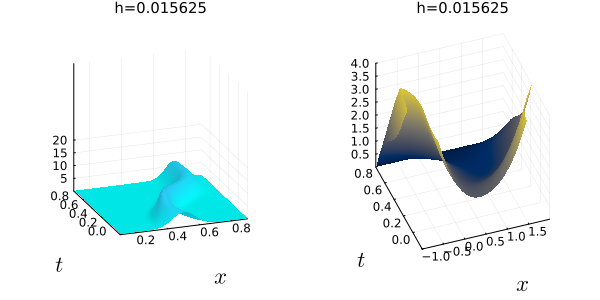

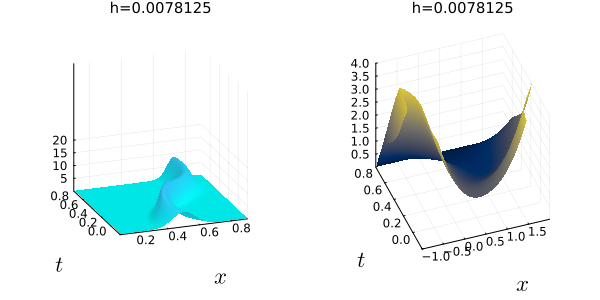

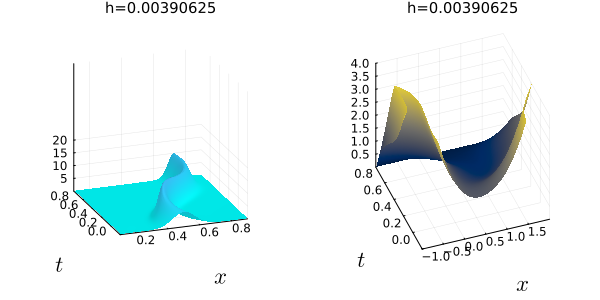

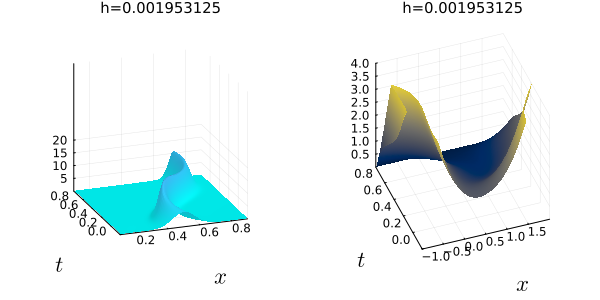

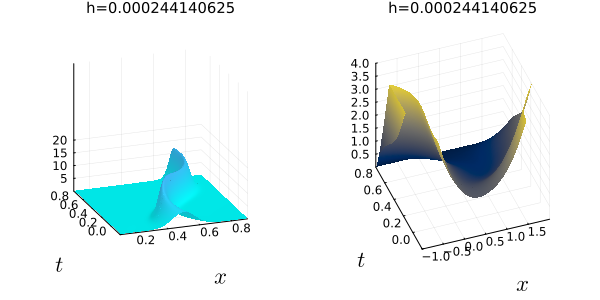

In [30]:
# plotusing Plots, LaTeXStrings;
using DelimitedFiles;
using Plots, LaTeXStrings;
println("HI")
println(h_list)
println("!!")
println("size(U_list): ", size(U_list))

for (i,h) in enumerate(h_list)
    println("----")
    println("i: ", i)
    x_vec = -1:h:(2-h);
    N_h =length(x_vec);
    
    α = 1.0 #1.5
    Δt = 0.01
    t_vec = 0:Δt:(1-Δt)
    N_T =length(t_vec)
    ν=0.09^2
    num_it_MFG=50
    num_it_HJB=20
    δ = 0.4
    R=30
    C_H = 0.5

    plot_U_mat = U_list[i];
    plot_M_mat = M_list[i];

    zticks1 = 5:5:20
    p1 = plot(t_vec, x_vec, plot_M_mat, ylabel=L"x", xlabel=L"t",  st=:surface, labelfontsize=15, zlim=(0,50),
    color=cgrad(:cool, rev=false), size=(500, 500), xlim=(0,t_vec[end]), ylim=(0.1,0.9), legend=false, camera=(90- 20, 20), xflip=true, zticks=zticks1, title=L"m(x,t)")
    zticks2 = 0.5:0.5:4
    p2 = plot(t_vec, x_vec, plot_U_mat, xlabel=L"t", ylabel=L"x",   st=:surface, labelfontsize=15,
    color=:cividis, size=(500, 500), xlim=(0,t_vec[end]), zlim=(0, 4), legend=false, camera=(90- 20, 40), xflip=true, zticks=zticks2, title=L"u(x,t)") # ylim=(0, 1),

    p = plot(p1, p2, layout=2, size=(600, 300), title="h="*string(h), titlefontsize=10)
    println("Display:")
    display(p)
    # println("i: ", i)
    # if i==1
    #     break
    # end
    println("!!!!!!!!!")
end

In [8]:
println("FINAL TIME PLOTS")

for (i,h) in enumerate(h_list)
    println("----")
    println("i: ", i)
    x_vec = -1:h:(2-h);
    N_h =length(x_vec);
    
    α = 1.0 #1.5
    Δt = 0.01
    t_vec = 0:Δt:(1-Δt)
    N_T =length(t_vec)
    ν=0.09^2
    num_it_MFG=50
    num_it_HJB=20
    δ = 0.4
    R=30
    C_H = 0.5

    time_index = div(length(t_vec),1)
    println("time_index: ", time_index)

    plot_U_mat_final = U_list[i][:,1];
    plot_M_mat_final = M_list[i][:,time_index];

    p1 = plot(x_vec, plot_M_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=15,
    color=cgrad(:cool, rev=false), size=(500, 500), legend=false, title=L"m(x,1-Δt)") #, xlim=(0,1) )
    zticks2 = 0.5:0.5:4
    p2 = plot(x_vec, plot_U_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=15,
    color=:cividis, size=(500, 500), legend=false, title=L"u(x,0)") #,xlim=(0, 1),)

    p = plot(p1, p2, layout=2, size=(400, 200), title="h="*string(h)*", t="*string(t_vec[time_index]), titlefontsize=10)
    println("Display:")
    display(p)
    # println("i: ", i)
    # if i==1
    #     break
    # end
    println("!!!!!!!!!")
end

FINAL TIME PLOTS


LoadError: LoadError: UndefVarError: `@L_str` not defined
in expression starting at c:\git_repositories\FractionalMFGs.jl\notebooks\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:26

In [22]:
#assume vec, wrt_vec same sizes

function relative_max_error(vec, wrt_vec)
    max_difference = maximum(abs.(vec-wrt_vec))
    max_rel_error = max_difference/maximum(abs.(wrt_vec))
    max_index_diff = argmax(abs.(vec-wrt_vec))
    max_index_wrt_vec = argmax(abs.(wrt_vec))
    println("max_index_diff: ", max_index_diff, ". Total length: ", length(vec), ". x-pos: ", string(-1+3*(max_index_diff/length(vec))) )
    println("max_index_wrt_vec: ", max_index_wrt_vec, ". Total length: ", length(vec), ". x-pos: ", string(-1+3*(max_index_wrt_vec/length(vec))))
    return max_rel_error
end

function relative_l1_error(vec, wrt_vec)
    println("length(vec): ", length(vec))
    println("length(wrt_vec): ", length(wrt_vec))
    l1 = sum(abs.(vec-wrt_vec)) #*h
    l1_rel_error = l1/sum(abs.(wrt_vec)) # *1/h, which cancels with h from l1
    return l1_rel_error
end

relative_l1_error (generic function with 1 method)

In [4]:
test = [-3,-2,-1,0,1,2,3,4,5]

ht = 0.01
t_vec = -1:ht:(2-ht);

t = [0,1,2,3,4,5,6,7,8]



test2= t_vec[ -2 .<= test .<= 3]
println(test2)
println(collect(t_vec))

BoundsError: BoundsError: attempt to access 300-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [9-element BitVector]

In [7]:
function U_convergence_rate(U_list, h_list)
    time_index = 1 #terminal codition, so at t=0
    U_reference = U_list[end][:,time_index]

    U_rel_errors_list = []

    for (i,h) in enumerate(h_list[1:end-1])
        x_vec = -1:h:(2-h);      

        println("i: ", i)
        println("h: ", h)
        println("step: ", 2^(abs(log2(h_list[end]))-abs(log2(h))))
        restriction_step = Int(2^(abs(log2(h_list[end]))-abs(log2(h))))
        println("restriction_step: ", restriction_step)
        restricted_U_reference = U_reference[begin:restriction_step:end]
        println("length(restricted_U_reference): ", length(restricted_U_reference))

        U_current = U_list[i][:,time_index]
        println("length(U_current): ", length(U_current))

        cropped_restricted_U_reference =  restricted_U_reference[0 .<= x_vec .<=1]
        cropped_U_current = U_current[0 .<= x_vec .<=1]
        cropped_x_vec = x_vec[0 .<= x_vec .<=1]

        println("length(x_vec): ", length(x_vec));
        println("length(cropped_x_vec): ", length(cropped_x_vec));
        println("collect(cropped_x_vec): ", collect(cropped))
        println("length(cropped_restricted_U_reference): ", length(cropped_restricted_U_reference))
        println("length(cropped_U_current): ", length(cropped_U_current))

        U_rel_error = relative_max_error(cropped_U_current, cropped_restricted_U_reference)
        push!(U_rel_errors_list, U_rel_error)
    end

    println("U CONV RATES")
    U_conv_rates = []
    for i in 1:length(U_rel_errors_list[1:end-1])
        println("i: ", i)
        rate = log(U_rel_errors_list[i]/U_rel_errors_list[i+1])/(log(h_list[i]/h_list[i+1]))
        push!(U_conv_rates, rate)
    end

    return U_rel_errors_list, U_conv_rates
end

function M_convergence_rate(M_list, h_list)
    Δt = 0.01
    t_vec = 0:Δt:(1-Δt)
    N_T =length(t_vec)
    time_index = N_T
    M_reference = M_list[end][:,time_index]
    println("length(M_reference): ", length(M_reference))
    M_rel_errors_list = []

    for (i,h) in enumerate(h_list[1:end-1])
        println("i: ", i)
        println("h: ", h)
        println("step: ", 2^(abs(log2(h_list[end]))-abs(log2(h))))
        restriction_step = Int(2^(abs(log2(h_list[end]))-abs(log2(h))))
        println("restriction_step: ", restriction_step)
        restricted_M_reference = M_reference[begin:restriction_step:end]
        println("length(restricted_M_reference): ", length(restricted_M_reference))

        M_current = M_list[i][:,time_index]
        println("length(M_current): ", length(M_current))

        M_rel_error = relative_l1_error(M_current, restricted_M_reference)
        push!(M_rel_errors_list, M_rel_error)
    end

    println("M CONV RATES")
    M_conv_rates = []
    for j in 1:length(M_rel_errors_list[1:end-1])
        println("j: ", j)
        rate = log(M_rel_errors_list[j]/M_rel_errors_list[j+1])/(log(h_list[j]/h_list[j+1]))
        push!(M_conv_rates, rate)
    end

    return M_rel_errors_list, M_conv_rates
end


M_convergence_rate (generic function with 1 method)

In [41]:
println(h_list)
println(length(M_list))
println(length(U_list))

[0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.000244140625]
6
6


In [25]:
(M_e, M_conv) = M_convergence_rate(M_list, h_list)
println("")


length(M_reference): 12288
i: 1
h: 0.03125
step: 128.0
restriction_step: 128
length(restricted_M_reference): 96
length(M_current): 96
length(vec): 96
length(wrt_vec): 96
i: 2
h: 0.015625
step: 64.0
restriction_step: 64
length(restricted_M_reference): 192
length(M_current): 192
length(vec): 192
length(wrt_vec): 192
i: 3
h: 0.0078125
step: 32.0
restriction_step: 32
length(restricted_M_reference): 384
length(M_current): 384
length(vec): 384
length(wrt_vec): 384
i: 4
h: 0.00390625
step: 16.0
restriction_step: 16
length(restricted_M_reference): 768
length(M_current): 768
length(vec): 768
length(wrt_vec): 768
i: 5
h: 0.001953125
step: 8.0
restriction_step: 8
length(restricted_M_reference): 1536
length(M_current): 1536
length(vec): 1536
length(wrt_vec): 1536
M CONV RATES
j: 1
j: 2
j: 3
j: 4



In [6]:
println("U:")
(U_e, U_conv) = U_convergence_rate(U_list, h_list)

U:


UndefVarError: UndefVarError: `U_list` not defined

In [20]:
println("M: ")
println(M_e)
println(M_conv)

println("U: ")
println(U_e)
println(U_conv)

M: 
Any[0.6827839651168374, 0.46987125695555637, 0.30595935478736547, 0.1760276322774664, 0.09135191375179307]
Any[0.5391636600488393, 0.6189255070262473, 0.7975380941461422, 0.9462950588544639]
U: 
Any[0.14297155403962325, 0.17250650903176054, 0.1702754559493065, 0.16939132578825566, 0.16661973625787796]
Any[-0.2709226653031585, 0.018780303512927345, 0.0075104964519638875, 0.023800699504759555]
